# Demonstration of Orthogonal Collocation
(Taken from Nonlinear Programming: Concepts, Algorithms, and Applications to Chemical Processes)

### 0. Introduction

Consider the ODE:
\begin{equation}
\dfrac{dz}{dt}= z^{2} - 2z + 1, z\left(0 \right) = -3
\end{equation}

To approximate the solution, the system can be discretized; for example, with **orthogonal collocation**.  
The purpose of this example is to show how to apply automatic discretization with pyomo.

### 1. Imports and model

In this kind of examples we must import *pyomo.dae*.

In [47]:
from pyomo.environ import *
from pyomo.dae import *  #: import the dae objects from pyomo
from pyomo.opt import *

To generate some plots, *pyplot* can be used.

In [48]:
import matplotlib.pyplot as plt

A simple Concrete model will be used.

In [49]:
m = ConcreteModel()

### 2. ContinuousSets

This is an infinite dimension problem that can be discretized. In a model this time dependency can be represented with a set.  
However, this set is not typically in the sense that it needs to represent the infinite dimensional problem.  
In pyomo, a special kind of set can be used for such purposes, the *ContinuousSet*.

In [50]:
m.t = ContinuousSet(bounds=(0,1))

*ContinuousSet* requires bounds over which the problem will be evaluated. These are declared with the `bounds` keyword. Note that the bounds are passed as a `tuple`.

### 3. Variables and Constraints

The dependent variables of this problem have to be defined over the time *ContinuousSet*. In this problem that set is called `m.t`

In [51]:
m.z = Var(m.t, initialize=1)

In pyomo, it is possible to create a model that combines differential and algebraic variables. The differential variables typically have a differential term, e.g. for the $z$ variable $\frac{dz}{dt}$.  
So, in pyomo this is done with the *DerivativeVar*. Note, that this class requires a base variable, in this case `m.z`.

In [52]:
m.dzdt = DerivativeVar(m.z)

The constraints of this problem involve the ODE itself and the initial condition.  
To specify the ODE itself, the easiest way is to declare a python function that returns the expression for the ODE.  
Also, note the `Constraint.Skip`  syntax for `t==0`. 

In [53]:
def _ode_rule(mod, t):  #: this will be passed to the constructor
    if t == 0:
        return Constraint.Skip
    else:
        return mod.dzdt[t] == mod.z[t] ** 2 - 2 * mod.z[t] + 1

Then the function is passed to the constraint as usual.  

In [54]:
m.c = Constraint(m.t, rule=_ode_rule)

The initial condition $z\left(0 \right) = z_{0}$ can be either specified with a *Constraint* or by fixing the variable $z$ at $t=0$.  
The two cases are presented.  

In [55]:
m.z[0].fix(-3.0)  #: fix the initial condition

In [56]:
#m._init_con = Constraint(expr=m.z[0] == -3.0)   #: or Create constraint

In [57]:
n = m.clone()  #: for educational purposes

### 4. Discretization

Pyomo offers a convenient way to discretize the model. So far it is possible to use either collocation over finite elements or finite diferences.  
Either way, a *TransformationFactory* object is used.  This object is constructed with the desired scheme. For instance collocation,

In [58]:
discretizer = TransformationFactory('dae.collocation')

Thus the discretization can be applied simply by using the `apply_to` method. This method takes the model as argument and the collocation points and finite elements as keyword arguments.

In [59]:
discretizer.apply_to(m, nfe=1, ncp=3)  #: use for instance one finite element and three collocation points

It should be noted that, once the discretizer is applied; the model will change significantly. This will create a set of discrete points for the ContinuousSet, create dummy variables, and appropiate discretization equations. The user should consider the changes that the model might have experienced as a result of this. Most notably the fact that before discretization objects defined over the ContinuousSet were only defined for the bounds of the set. At no point before discretization these existed in between the bounds. For example, a reference `x[0.5]` is not valid and will result in an exception being raised.  
This is not the case after discretization, because such objects might exist. In fact, by inspection `m.t` now has the following elements,

In [60]:
m.t.pprint()  #: print the current elements

t : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=Sorted, Bounds=(0, 1)
    [0, 0.155051, 0.644949, 1]


Thus, referencing `m.x[0.5]` is only possible after discretization. The *DerivativeVar* objects will be transformed into regular *Var* objects, and furthermore the discretization equations will be created, that is:

In [61]:
m.dzdt_disc_eq.pprint()  #: this will be automatically generated

dzdt_disc_eq : Size=3, Index=t, Active=True
    Key      : Lower : Body                                                                                                                                   : Upper : Active
    0.155051 :   0.0 : dzdt[0.155051] - (-4.139387691339813*z[0] + 3.2247448713915885*z[0.155051] + 1.1678400846904051*z[0.644949] - 0.2531972647421808*z[1]) :   0.0 :   True
    0.644949 :   0.0 : dzdt[0.644949] - (1.7393876913398163*z[0] - 3.5678400846904044*z[0.155051] + 0.7752551286084095*z[0.644949] + 1.0531972647421817*z[1]) :   0.0 :   True
           1 :   0.0 :           dzdt[1] - (-2.999999999999993*z[0] + 5.531972647421805*z[0.155051] - 7.531972647421807*z[0.644949] + 5.000000000000001*z[1]) :   0.0 :   True


### 5. Solution

Though, this model has no initial guesses at the moment, it is possible to attempt solving it.

In [62]:
ipopt = SolverFactory('ipopt')
results = ipopt.solve(m, tee=False)  #: Solve!
if results.solver.termination_condition == TerminationCondition.optimal:
    print("Success!")

Success!


After that it is possible to use *pyplot* to visualize the results:

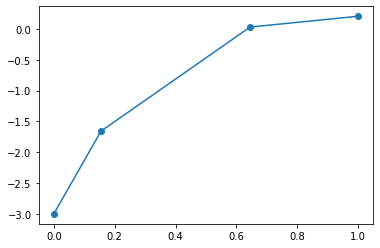

In [63]:
tl = []
zl = []
for key in m.t:
    tl.append(key)
    zl.append(value(m.z[key]))

fig = plt.plot(tl, zl, 'o-')
plt.show()

### Optional
It is also possible to try to solve the problem with more finite elements.

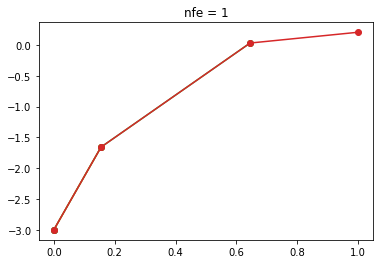

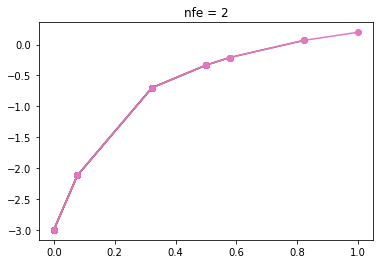

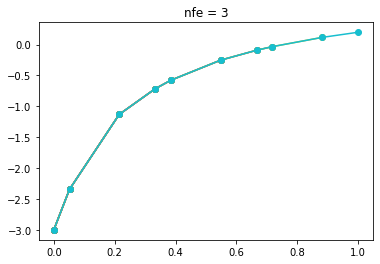

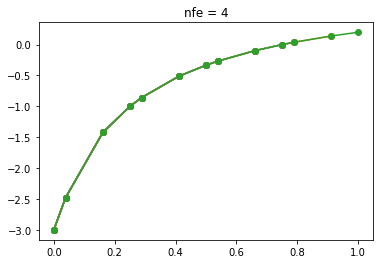

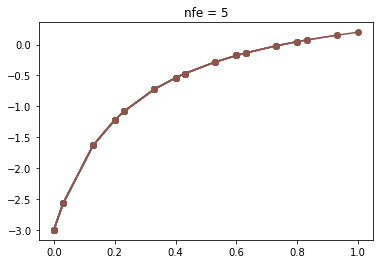

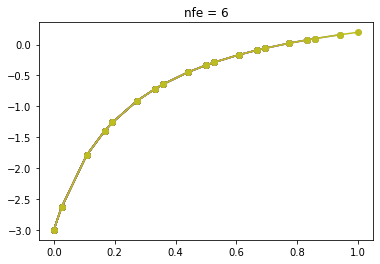

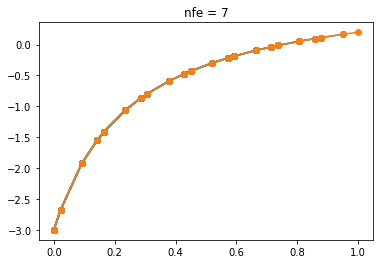

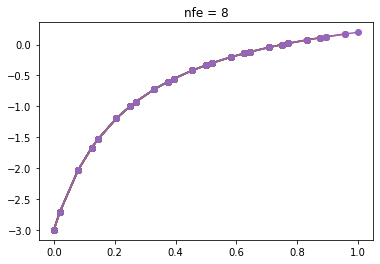

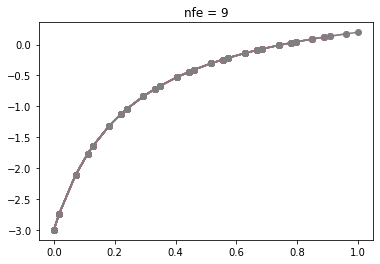

In [67]:
for i in range(1, 10):
    d = TransformationFactory("dae.collocation")
    mod = n.clone()
    d.apply_to(mod, nfe=i, ncp=3)
    res = ipopt.solve(mod)
    tl = []
    zl = []
    for key in mod.t:
        tl.append(key)
        zl.append(value(mod.z[key]))
        fig = plt.plot(tl, zl, 'o-')
        plt.title("nfe = {}".format(i))
    plt.show()  #: Magic
    

### Credits:
 - David Thierry (Carnegie Mellon University @2019)